In [1]:
import os
os.chdir("..")
from pathlib import Path

In [2]:
import models
import dataset_processing
import torch
import helpers

/Users/lucah/Library/CloudStorage/OneDrive-DurhamUniversity/cs_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [134]:
resnet = models.get_model_type("ConvNeXtSmall")(False, 3, 10).to("mps")
len(torch.nn.utils.parameters_to_vector(resnet.parameters()))

KeyboardInterrupt: 

In [4]:
ds = dataset_processing.get_dataset_object("UCMerced", "val", resnet.expected_input_dim, 32, 4, torch.device("mps"))

In [110]:
import importlib

In [127]:
import xai
importlib.reload(xai.shap_method)
importlib.reload(helpers.plotting)

<module 'helpers.plotting' from '/Users/lucah/Library/CloudStorage/OneDrive-DurhamUniversity/cs_project/helpers/plotting.py'>

In [128]:
exp = xai.get_explainer_object("PartitionSHAP", resnet, Path("partition_testing"), batch_size=32)

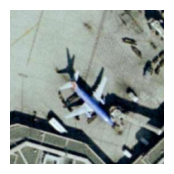

In [129]:
img = ds[23]["image"]
helpers.plotting.show_image(img, final_fig_size=(2, 2))

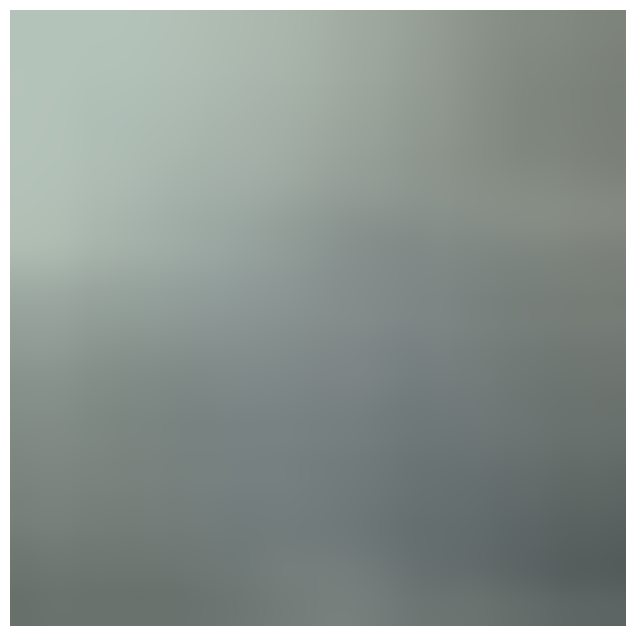

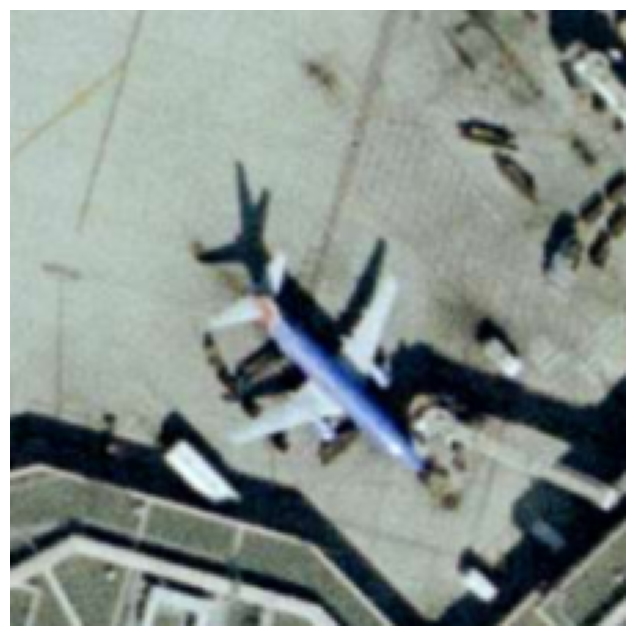

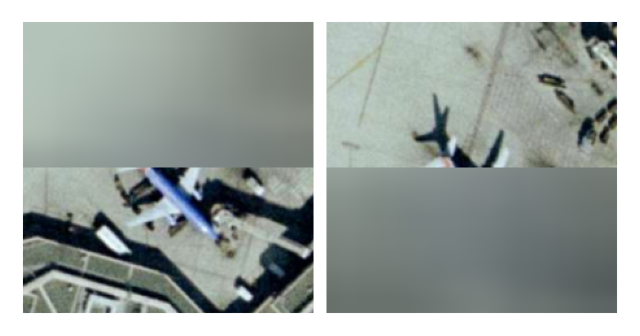

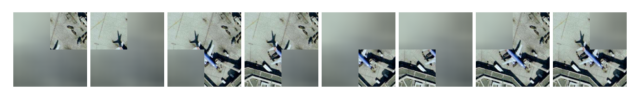

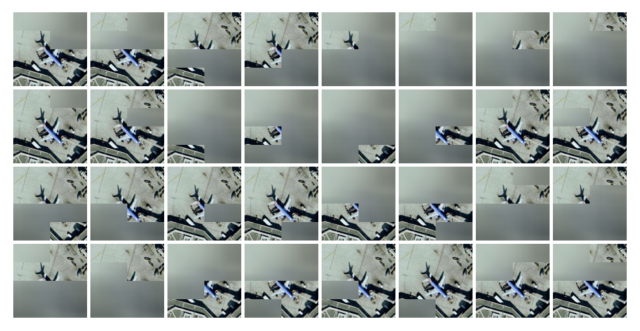

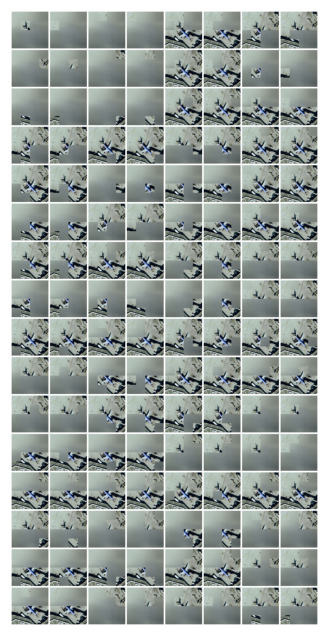

KeyboardInterrupt: 

In [131]:
exp.explain(img.unsqueeze(0), max_evals=3000, shap_batch_size=128)

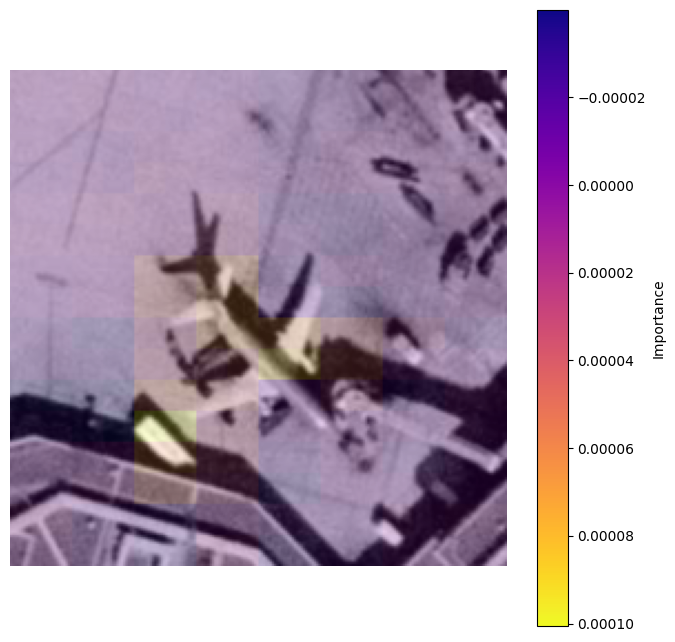

In [109]:
helpers.plotting.visualise_importance(exp.input.cpu().numpy().transpose(0, 2, 3, 1), exp.explanation)

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import cv2

In [36]:
exp._raw_return.clustering.shape

(1, 150527, 4)

In [42]:
import pandas as pd
masks = pd.read_csv("output/batch_masks.csv", header=None, index_col=0)

In [46]:
np_masks = masks.to_numpy().reshape(-1, resnet.expected_input_dim, resnet.expected_input_dim, 3).astype(bool)
np_masks.shape

(32, 224, 224, 3)

In [90]:
repeated_img = img.unsqueeze(0).repeat(np_masks.shape[0], 1, 1, 1)
repeated_img.shape, torch.from_numpy(np_masks.transpose(0, 3, 1, 2)).shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224]))

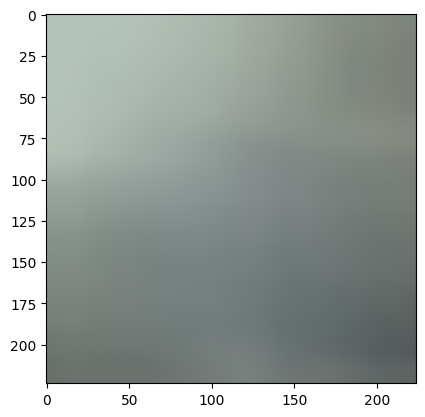

In [92]:
blurred_img = cv2.blur(img.cpu().numpy().transpose(1, 2, 0), (128, 128))
plt.imshow((blurred_img+1)/2)

In [98]:
masked_imgs = torch.where(
    torch.from_numpy(np_masks.transpose(0, 3, 1, 2)),
    repeated_img,  # if mask is True, keep the original image (feature is present)
    torch.from_numpy(blurred_img.transpose(2, 0, 1)).unsqueeze(0).repeat(np_masks.shape[0], 1, 1, 1),  # if mask is False, use the blurred image (feature 'removed')
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0].


True


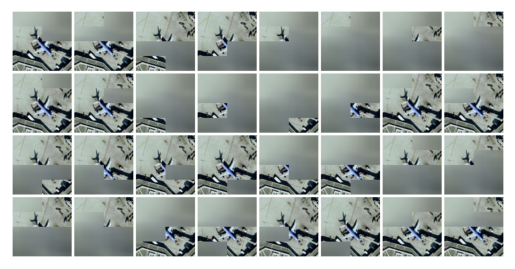

In [100]:
print(np_masks[0, 200,200,0])  # black is False
plt.imshow(torchvision.utils.make_grid((masked_imgs+1)/2, padding=10, pad_value=1).numpy().transpose(1, 2, 0), cmap="gray")
_ = plt.axis('off')